In [1]:
#we'll install the package pympler to track the memory usage of code throughout the notebook.
#SummaryTracker (tr) will print a new summary of the current state compared to any previous summary and prints to the console.

!pip install pympler
from pympler import tracker
tr = tracker.SummaryTracker()
tr.print_diff()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 1.5 MB/s eta 0:00:00
                                  types |   # objects |   total size
======================================= | =========== | ============
                                   list |       14560 |      3.43 MB
                                    str |       14549 |      1.03 MB
                                    int |        3220 |     88.05 KB
                                   dict |          53 |     10.52 KB
                                   code |           2 |    600     B
                                  bytes |           2 |    549     B
             frame (codename: run_cell) |           2 |    456     B
                              generator |           1 |    376     B
                frame (codename: start) |           2 |    352     B
                              coroutine |           1 |    320     B
            frame (codename: _run_cell) |           1 |    312     B
            frame (code

In [2]:
#import all relevant packages

import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from lightgbm import LGBMClassifier
from time import perf_counter
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder as le
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.svm import LinearSVC
from google.colab import files
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
tr.print_diff()

                    types |   # objects |   total size
========================= | =========== | ============
                      str |      287334 |     58.00 MB
                     code |       90382 |     37.46 MB
                     dict |       88983 |     24.80 MB
                     type |       10538 |     12.56 MB
                    tuple |      111148 |      7.08 MB
  collections.OrderedDict |        7003 |      3.40 MB
              abc.ABCMeta |        1213 |      1.89 MB
        inspect.Parameter |       30866 |      1.88 MB
                      set |        4606 |      1.71 MB
                     cell |       33208 |      1.27 MB
    weakref.ReferenceType |       16122 |      1.23 MB
                frozenset |        2858 |    962.86 KB
      function (__init__) |        5577 |    827.84 KB
       nanobind.nb_type_0 |         518 |    693.39 KB
        getset_descriptor |       10928 |    683.00 KB


# Splitting into Train and Test sets
Using the cleaned datafile from exploratory data analysis, start the resampling process to make two datasets: SMOTE Resampled and KMeans SMOTE Resampled.

In [4]:
#import and read the preprocessed dataset
#os.chdir("/clean_BNPL_clients.csv")

bnpl = pd.read_csv('clean_BNPL_python.csv')

In [5]:
#identify the numerical categories

bnpl_continuous = bnpl[['loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc', 'total_dti', 'tot_coll_amt', 'tot_cur_bal', \
                                  'total_bal_ex_mort','credit_limit']]

#identify categorical categories

bnpl_categor = bnpl[['loan_term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_purpose', \
                               'delinq_2yrs', 'open_acc','addr_state', 'application_type', 'cur_acct_delinq', 'mort_acc', \
                               'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', \
                               'debt_settlement_flag']]
#source the column indices
bnpl_categor_indx = [bnpl.columns.get_loc(col) for col in bnpl_categor]

In [6]:
#enact one-hot encoding
bnpl_num = pd.get_dummies(bnpl, columns=bnpl_categor.columns,
                          prefix = bnpl_categor.columns)

In [7]:
#split the data into training and test sets

#first split by attributes and targets
bnpl_att = bnpl_num.drop(['loan_status'], axis=1)
bnpl_tar = bnpl_num['loan_status']

#split the data into train and test sets
bnpl_att_train, bnpl_att_test, bnpl_tar_train, bnpl_tar_test = train_test_split(bnpl_att, bnpl_tar, test_size=0.3, random_state=55)

## SMOTE Resampling

In [8]:
#resample the data with SMOTE, which will go on to be used in the models

bnpl_smote = SMOTE(random_state=1000)

bnpl_att_train_resample, bnpl_tar_train_resample = bnpl_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

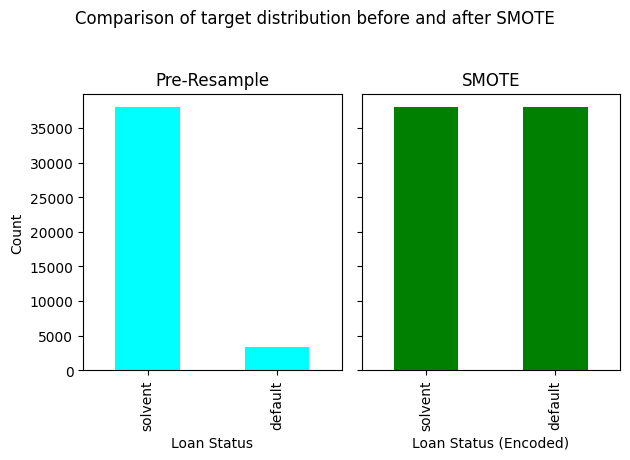

In [9]:
#use matplotlib to visualize resampling

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Comparison of target distribution before and after SMOTE')

# Plot pre-resample target distribution on ax1
bnpl_tar_train.value_counts().plot(kind="bar", color="cyan", ax=ax1)
ax1.set_title("Pre-Resample")
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

# Plot post-resample target distribution on ax2
bnpl_tar_train_resample.value_counts().plot(kind='bar', color="green", ax=ax2)
ax2.set_title("SMOTE")
ax2.set_xlabel('Loan Status (Encoded)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## KMeans SMOTE Resampling

In [10]:
#resample the data with k-means SMOTE methods

bnpl_km_smote = KMeansSMOTE(random_state=1000, cluster_balance_threshold=0.1, kmeans_estimator=30)

bnpl_att_train_km_resample, bnpl_tar_train_km_resample = bnpl_km_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

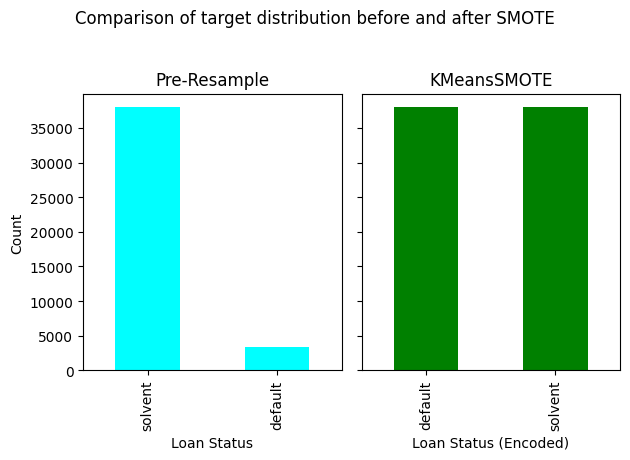

In [11]:
#use matplotlib to visualize resampling

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Comparison of target distribution before and after SMOTE')

# Plot pre-resample target distribution on ax1
bnpl_tar_train.value_counts().plot(kind="bar", color="cyan", ax=ax1)
ax1.set_title("Pre-Resample")
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

# Plot post-resample target distribution on ax2
bnpl_tar_train_km_resample.value_counts().plot(kind='bar', color="green", ax=ax2)
ax2.set_title("KMeansSMOTE")
ax2.set_xlabel('Loan Status (Encoded)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [12]:
tr = tracker.SummaryTracker()
tr.print_diff()

                                              types |   # objects |   total size
=================================================== | =========== | ============
                          pandas.core.series.Series |        1724 |    331.39 MB
                                               dict |        8635 |      1.36 MB
                              weakref.ReferenceType |        3562 |    278.28 KB
                                      numpy.ndarray |        1732 |    198.55 KB
                                              tuple |        3264 |    164.30 KB
            pandas.core.internals.blocks.NumpyBlock |        1724 |    161.62 KB
                                               list |        2022 |    131.13 KB
              pandas._libs.internals.BlockPlacement |        1724 |    121.22 KB
  pandas.core.internals.managers.SingleBlockManager |        1724 |     94.28 KB
                                              slice |        1724 |     94.28 KB
                            

# Model Development

## Baseline Model: Logistic Regression
Develop a logistic regression model for a baseline model the experimental models will be compared to

### Using SMOTE Resampled data

In [13]:
#initialize log reg model
bnpl_log_reg = LogisticRegression()

In [14]:
#scale the training data

scaler = MinMaxScaler()
bnpl_att_train_resample_scaled = scaler.fit_transform(bnpl_att_train_resample)

In [15]:
#conduct cross-validation

lgrg_cv_scores = cross_val_score(bnpl_log_reg, bnpl_att_train_resample_scaled, bnpl_tar_train_resample, cv= 5, scoring ="accuracy")

print("Cross-Validation Accuracy Scores on Training Set:", lgrg_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", lgrg_cv_scores.mean())

Cross-Validation Accuracy Scores on Training Set: [0.8002103  0.99967138 0.99953993 0.99967138 0.9994742 ]
Average Cross-Validation Accuracy on Training Set: 0.9597134379190937


In [16]:
#train the model on the train dataset, resampled with SMOTE and target variables scaled

#include a timer to track the execution
time_start = perf_counter()

#train model
bnpl_log_reg.fit(bnpl_att_train_resample_scaled, bnpl_tar_train_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 5.148145319999998 seconds


In [17]:
#scale the test attributes
bnpl_att_test_scaled = scaler.fit_transform(bnpl_att_test)

#collect test predictions in a variable
tar_pred_test_lgrg = bnpl_log_reg.predict(bnpl_att_test_scaled)

#calculate the evaluation metrics
lgrg_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgrg)
lgrg_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='solvent')
lgrg_specificity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='default')
lgrg_f1 = f1_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label = 'solvent')

#display the results
print("Test Accuracy:", lgrg_testaccuracy)
print("Sensitivity (Recall for Default):", lgrg_sensitivity)
print("Specificity (Recall for Solvent):", lgrg_specificity)
print("F1 Score:", lgrg_f1)

Test Accuracy: 0.9318130503499661
Sensitivity (Recall for Default): 0.9996325330720235
Specificity (Recall for Solvent): 0.1340057636887608
F1 Score: 0.9643152546378353


In [18]:
#calculate confusion matrix
lgrg_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_lgrg)

# Extract TP, FP, TN, FN from the confusion matrix
lgrg_tn, lgrg_fp, lgrg_fn, lgrg_tp = lgrg_conmatx.ravel()
print("True Negatives (TN):", lgrg_tn)
print("False Positives (FP):", lgrg_fp)
print("False Negatives (FN):", lgrg_fn)
print("True Positives (TP):", lgrg_tp)

True Negatives (TN): 186
False Positives (FP): 1202
False Negatives (FN): 6
True Positives (TP): 16322


<Axes: >

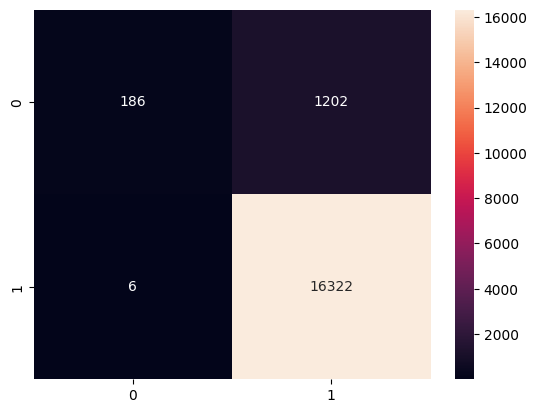

In [19]:
#display the confusion matrix
sns.heatmap(lgrg_conmatx, annot=True, fmt='d')

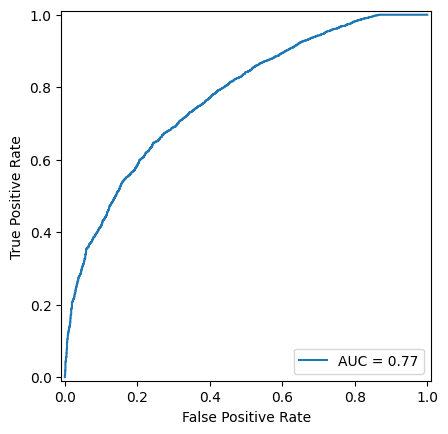

In [20]:
#calculate area under the curve
lgrg_fpr, lgrg_tpr, lgrg_threshold = roc_curve(bnpl_tar_test, (bnpl_log_reg.predict_proba(bnpl_att_test_scaled)[:, 1]), pos_label='solvent')

bnpl_lgrg_roc_auc = auc(lgrg_fpr, lgrg_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=lgrg_fpr, tpr=lgrg_tpr, roc_auc=bnpl_lgrg_roc_auc)
display.plot()

In [21]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |        2804 |    888.34 KB
                      numpy.ndarray |         768 |    385.07 KB
                                set |         326 |    141.27 KB
                              tuple |        1985 |    113.62 KB
                               list |        1452 |     88.85 KB
              weakref.ReferenceType |         919 |     71.80 KB
                function (<lambda>) |         474 |     70.36 KB
         builtin_function_or_method |         889 |     62.51 KB
                    itertools.count |         315 |     17.23 KB
       matplotlib.cbook._UnhashDict |         313 |     17.12 KB
  matplotlib.cbook.CallbackRegistry |         313 |     17.12 KB
          matplotlib.artist._XYPair |         292 |     15.97 KB
                                str |         136 |     14.43 KB
                         

### Using KMeans SMOTE Resampled data

In [22]:
#initialize log reg model for KMeans SMOTE
bnpl_log_reg_km = LogisticRegression()

In [23]:
#scale the trainig data
bnpl_att_train_km_resample_scaled = scaler.fit_transform(bnpl_att_train_km_resample)

In [24]:
#conduct cross-validation
lgrg_km_cv_scores = cross_val_score(bnpl_log_reg_km, bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample, cv= 5, scoring ="accuracy")

print("Cross-Validation Accuracy Scores on Training Set:", lgrg_km_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", lgrg_km_cv_scores.mean())

Cross-Validation Accuracy Scores on Training Set: [0.80153775 0.99973714 0.99980285 0.99973714 0.99953999]
Average Cross-Validation Accuracy on Training Set: 0.9600709732535979


In [25]:
#train the model on the training dataset

#include a timer to track the execution
time_start = perf_counter()

#train the model
bnpl_log_reg_km.fit(bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 4.429896704999976 seconds


In [26]:
#the scaled variable is already available

#collect the test attributes in a variable
tar_pred_test_lgrg_km = bnpl_log_reg_km.predict(bnpl_att_test_scaled)

#calculate the evaluation metrics
lgrg_km_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgrg_km)
lgrg_km_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgrg_km, pos_label='solvent')
lgrg_km_specificity = recall_score(bnpl_tar_test, tar_pred_test_lgrg_km, pos_label='default')
lgrg_km_f1 = f1_score(bnpl_tar_test, tar_pred_test_lgrg_km, pos_label = 'solvent')

#display the results
print("Test Accuracy:", lgrg_km_testaccuracy)
print("Sensitivity (Recall for Default):", lgrg_km_sensitivity)
print("Specificity (Recall for Solvent):", lgrg_km_specificity)
print("F1 Score:", lgrg_km_f1)

Test Accuracy: 0.9318694965003387
Sensitivity (Recall for Default): 0.9996937775600196
Specificity (Recall for Solvent): 0.1340057636887608
F1 Score: 0.9643458482261542


In [27]:
#calculate confusion matrix
lgrg_km_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_lgrg_km)

#extract TP, FP, TN, FN from the confusion matrix
lgrg_km_tn, lgrg_km_fp, lgrg_km_fn, lgrg_km_tp = lgrg_km_conmatx.ravel()
print("True Negatives (TN):", lgrg_km_tn)
print("False Positives (FP):", lgrg_km_fp)
print("False Negatives (FN):", lgrg_km_fn)
print("True Positives (TP):", lgrg_km_tp)

True Negatives (TN): 186
False Positives (FP): 1202
False Negatives (FN): 5
True Positives (TP): 16323


<Axes: >

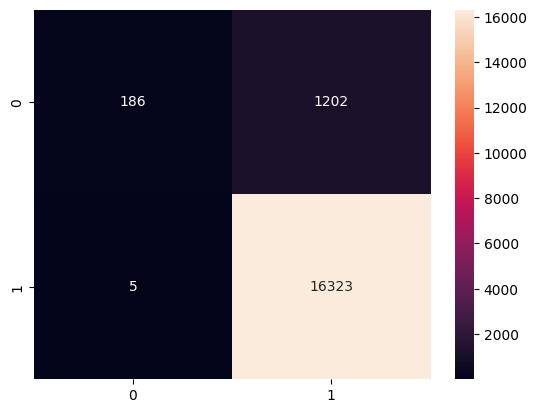

In [134]:
#display confusion matrix plot
sns.heatmap(lgrg_km_conmatx, annot=True, fmt='d')

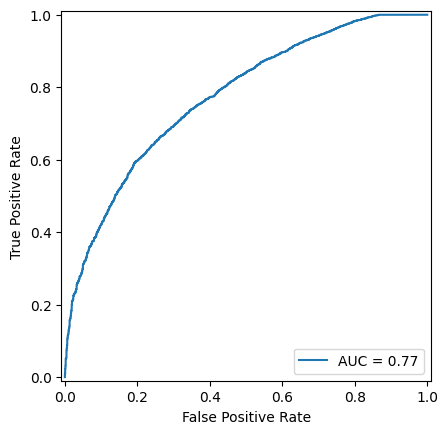

In [29]:
#calculate area under the curve
lgrg_km_fpr, lgrg_km_tpr, lgrg_km_threshold = roc_curve(bnpl_tar_test, (bnpl_log_reg_km.predict_proba(bnpl_att_test_scaled)[:, 1]), pos_label='solvent')

bnpl_lgrg_km_roc_auc = auc(lgrg_km_fpr, lgrg_km_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=lgrg_km_fpr, tpr=lgrg_km_tpr, roc_auc=bnpl_lgrg_km_roc_auc)
display.plot()

In [30]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |        2769 |    922.46 KB
                      numpy.ndarray |         767 |    384.62 KB
                               list |        1469 |     90.27 KB
                function (<lambda>) |         491 |     72.88 KB
                                set |         325 |     69.55 KB
                              tuple |        1104 |     61.78 KB
              weakref.ReferenceType |         514 |     40.16 KB
         builtin_function_or_method |         495 |     34.80 KB
                    itertools.count |         315 |     17.23 KB
       matplotlib.cbook._UnhashDict |         313 |     17.12 KB
  matplotlib.cbook.CallbackRegistry |         313 |     17.12 KB
          matplotlib.artist._XYPair |         292 |     15.97 KB
                                str |         139 |     15.18 KB
                         

## Random Forest Classifier

### Using SMOTE data

In [31]:
#build a random forest model
#for SMOTE resampling

bnpl_rf = RandomForestClassifier(max_features=50,
                                 max_depth=5,
                                 random_state=0,
                                 n_estimators=100)

Scaling the data typically yeilds an increase in accuracy, but across the experiments scaling did not assist in improving accuracy on the Random Forest like it did with Logistic Regression, Support Vector Machine, LightGBM, or Neural Network.

To visualize why scaling was not used in the Random Forest, a timer was added to the cross validation to see how it increases computational time without the benefit of increased accuracy.

In [32]:
#perform cross validation on the model prior to training and display

time_start = perf_counter()
rf_scores = cross_val_score(bnpl_rf, bnpl_att_train_resample, bnpl_tar_train_resample, cv=5)
time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')
print("Cross-Validation Accuracy Scores on Training Set:", rf_scores)
print("Average Cross-Validation Accuracy on Training Set: %0.2f (=/- %0.2f)"% (rf_scores.mean(), rf_scores.std()*2))

Took 76.74008662099999 seconds
Cross-Validation Accuracy Scores on Training Set: [0.7778654  0.87170555 0.88478475 0.87893526 0.89208018]
Average Cross-Validation Accuracy on Training Set: 0.86 (=/- 0.08)


In [33]:
#scale the training data
scaler = MinMaxScaler()
bnpl_att_train_resample_scaled = scaler.fit_transform(bnpl_att_train_resample)

#perform cross validation on the model prior to training and display

time_start = perf_counter()
rf_scores = cross_val_score(bnpl_rf, bnpl_att_train_resample_scaled, bnpl_tar_train_resample, cv=5)
time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')
print("Cross-Validation Accuracy Scores on Training Set:", rf_scores)
print("Average Cross-Validation Accuracy on Training Set: %0.2f (=/- %0.2f)"% (rf_scores.mean(), rf_scores.std()*2))

Took 78.40939744600001 seconds
Cross-Validation Accuracy Scores on Training Set: [0.7778654  0.87170555 0.88478475 0.87893526 0.89208018]
Average Cross-Validation Accuracy on Training Set: 0.86 (=/- 0.08)


In [34]:
#fit the model to SMOTE resampling

#include a timer to track the execution
time_start = perf_counter()

#fit model
bnpl_rf.fit(bnpl_att_train_resample, bnpl_tar_train_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 16.681064624000044 seconds
1664.51


In [35]:
#collect test prediction variable
tar_pred_test_rf = bnpl_rf.predict(bnpl_att_test)

#calculate evaluation metrics

rf_accuracy = accuracy_score(bnpl_tar_test, tar_pred_test_rf)
rf_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_rf, pos_label='solvent')
rf_specificity = recall_score(bnpl_tar_test, tar_pred_test_rf, pos_label='default')
rf_f1 = f1_score(bnpl_tar_test, tar_pred_test_rf, pos_label = 'solvent')

# Output the results
print("Test Accuracy:", rf_accuracy)
print("Sensitivity (Recall for Default):", rf_sensitivity)
print("Specificity (Recall for Solvent):", rf_specificity)
print("F1 Score:", rf_f1)

Test Accuracy: 0.8307179950327388
Sensitivity (Recall for Default): 0.8639759921607055
Specificity (Recall for Solvent): 0.43948126801152737
F1 Score: 0.9039182391952071


In [36]:
#calculate confusion matrix

rf_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_rf)

# Extract TP, FP, TN, FN from the confusion matrix
rf_tn, rf_fp, rf_fn, rf_tp = rf_conmatx.ravel()
print("True Negatives (TN):", rf_tn)
print("False Positives (FP):", rf_fp)
print("False Negatives (FN):", rf_fn)
print("True Positives (TP):", rf_tp)

True Negatives (TN): 610
False Positives (FP): 778
False Negatives (FN): 2221
True Positives (TP): 14107


<Axes: >

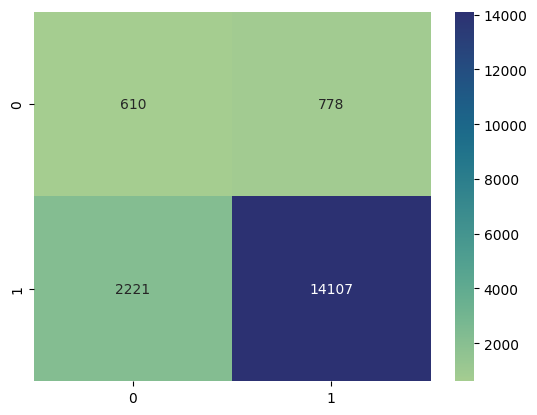

In [135]:
#display confusion matrix
sns.heatmap(rf_conmatx, annot=True, fmt='d', cmap = 'crest')

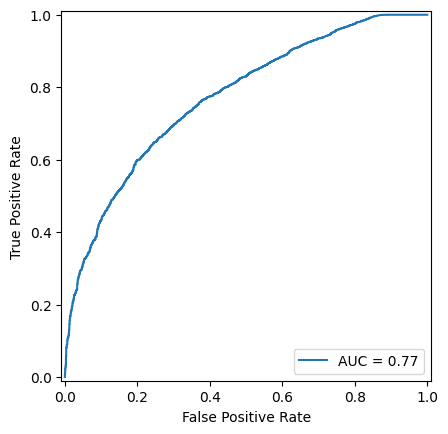

In [149]:
#calculate area under the curve
rf_fpr, rf_tpr, rf_threshold = roc_curve(bnpl_tar_test, (bnpl_rf.predict_proba(bnpl_att_test)[:, 1]), pos_label='solvent')

bnpl_rf_roc_auc = auc(rf_fpr, rf_tpr)

#display AUC curve plot
rf_conmatx_display = RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc=bnpl_rf_roc_auc)
rf_conmatx_display.plot()

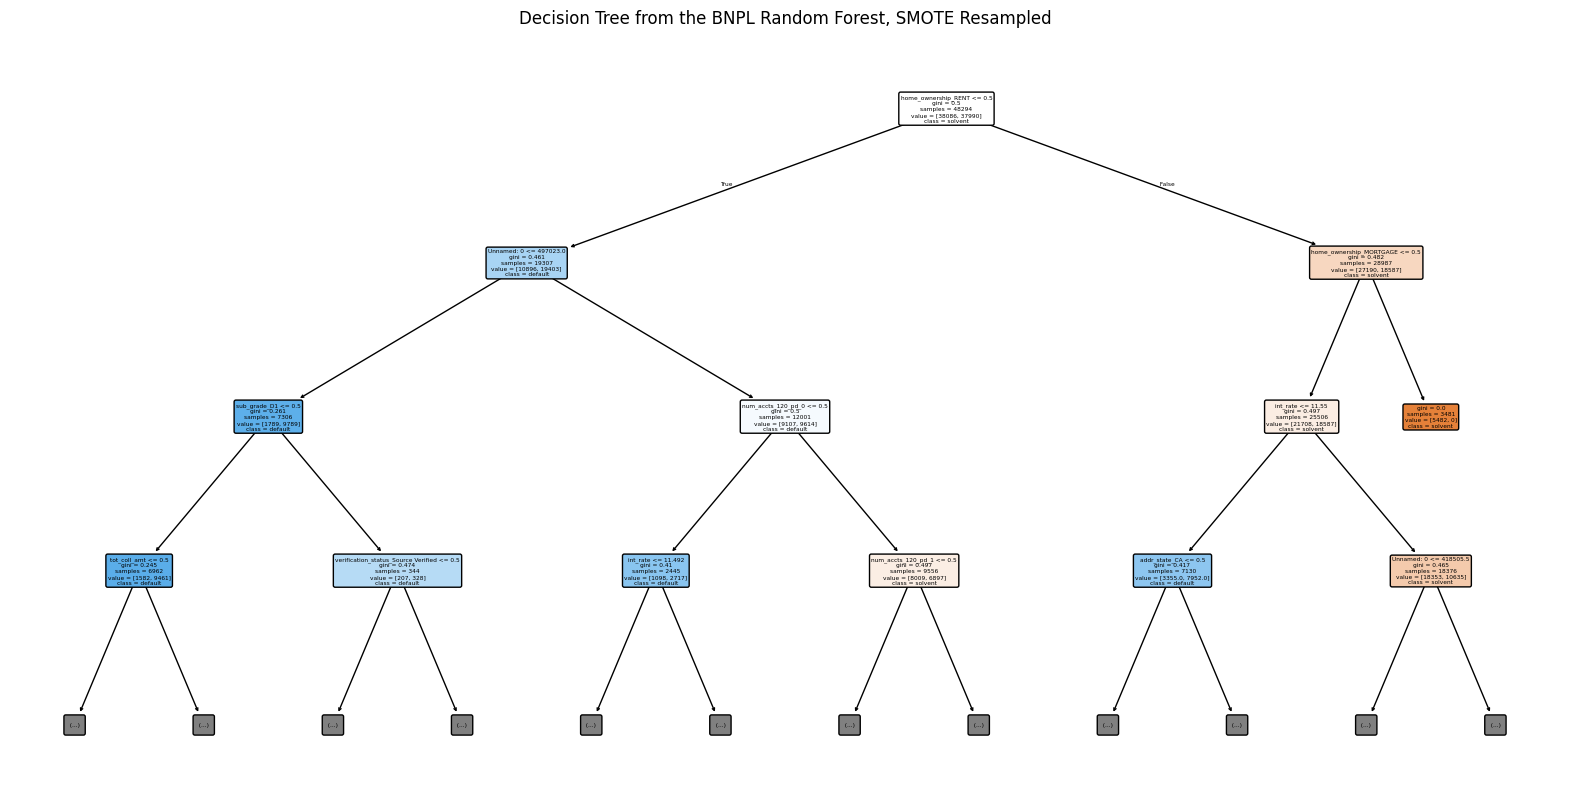

In [39]:
#Visualize a tree from the random forest

# capture feature names and class names for ease of use
rf_features = bnpl_att_train_resample.columns
rf_class_names = ['solvent', 'default']

#plot the tree
tree_rf_smote = bnpl_rf.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree_rf_smote,
          feature_names=rf_features,
          class_names=rf_class_names,
          filled=True,
          rounded=True,
          max_depth = 3)  #limit max depth otherwise text too small to read
plt.title("Decision Tree from the BNPL Random Forest, SMOTE Resampled")
plt.show()

In [40]:
tr.print_diff()

                                   types |   # objects |   total size
======================================== | =========== | ============
                                    dict |        2435 |    865.38 KB
                           numpy.ndarray |         751 |    417.55 KB
                                   tuple |        1568 |     93.95 KB
                                    list |        1423 |     88.40 KB
                     function (<lambda>) |         477 |     70.80 KB
                                     set |         321 |     69.21 KB
                   weakref.ReferenceType |         609 |     47.58 KB
              builtin_function_or_method |         578 |     40.64 KB
                                     str |         376 |     35.25 KB
  matplotlib.font_manager.FontProperties |         333 |     18.21 KB
                         itertools.count |         309 |     16.90 KB
            matplotlib.cbook._UnhashDict |         307 |     16.79 KB
       matplotlib.cb

### Using KMeans SMOTE Resampled Data


In [41]:
#develop another Random Forest Model

bnpl_rf_km = RandomForestClassifier(max_features=50,
                                    max_depth=5,
                                    random_state=0,
                                    n_estimators=100)

In [42]:
#perform cross validation on the model prior to training and display

rf_km_scores = cross_val_score(bnpl_rf_km, bnpl_att_train_km_resample, bnpl_tar_train_km_resample, cv=5)

print("Cross-Validation Accuracy Scores on Training Set:", rf_km_scores)
print("Average Cross-Validation Accuracy on Training Set: %0.2f (=/- %0.2f)"% (rf_km_scores.mean(), rf_km_scores.std()*2))

Cross-Validation Accuracy Scores on Training Set: [0.79194322 0.94394427 0.92797529 0.93842413 0.93684695]
Average Cross-Validation Accuracy on Training Set: 0.91 (=/- 0.12)


In [43]:
#fit the model to the KM SMOTE Resampling data

#include a timer to track the execution
time_start = perf_counter()

bnpl_rf_km.fit(bnpl_att_train_km_resample, bnpl_tar_train_km_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 17.450076773999967 seconds


In [44]:
#collect the test prediction variable
tar_pred_test_rf_km = bnpl_rf_km.predict(bnpl_att_test)

#calculate evaluation metrics

rf_km_accuracy = accuracy_score(bnpl_tar_test, tar_pred_test_rf_km)
rf_km_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_rf_km, pos_label='solvent')
rf_km_specificity = recall_score(bnpl_tar_test, tar_pred_test_rf_km, pos_label='default')
rf_km_f1 = f1_score(bnpl_tar_test, tar_pred_test_rf_km, pos_label = 'solvent')

# Output the results
print("Test Accuracy:", rf_km_accuracy)
print("Sensitivity (Recall for Default):", rf_km_sensitivity)
print("Specificity (Recall for Solvent):", rf_km_specificity)
print("F1 Score:", rf_km_f1)

Test Accuracy: 0.8520546398735607
Sensitivity (Recall for Default): 0.8936183243508085
Specificity (Recall for Solvent): 0.3631123919308357
F1 Score: 0.917586391220954


In [137]:
#calculate confusion matrix
rf_km_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_rf_km)

# Extract TP, FP, TN, FN from the confusion matrix
rf_km_tn, rf_km_fp, rf_km_fn, rf_km_tp = rf_conmatx.ravel()
print("True Negatives (TN):", rf_km_tn)
print("False Positives (FP):", rf_km_fp)
print("False Negatives (FN):", rf_km_fn)
print("True Positives (TP):", rf_km_tp)

True Negatives (TN): 610
False Positives (FP): 778
False Negatives (FN): 2221
True Positives (TP): 14107


<Axes: >

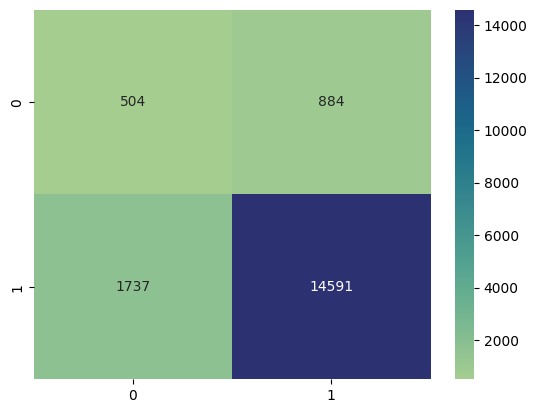

In [138]:
sns.heatmap(rf_km_conmatx, annot=True, fmt='d', cmap = 'crest')

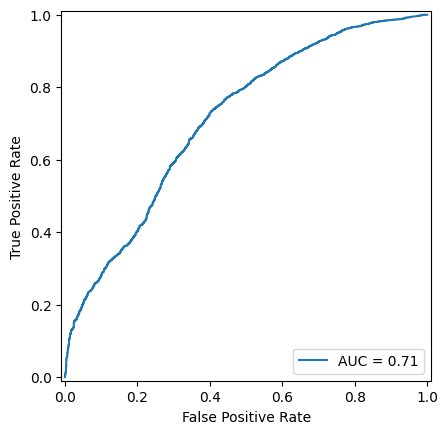

In [47]:
#calculate area under the curve
rf_km_fpr, rf_km_tpr, rf_km_threshold = roc_curve(bnpl_tar_test, (bnpl_rf_km.predict_proba(bnpl_att_test)[:, 1]), pos_label='solvent')

bnpl_rf_km_roc_auc = auc(rf_km_fpr, rf_km_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=rf_km_fpr, tpr=rf_km_tpr, roc_auc=bnpl_rf_km_roc_auc)
display.plot()

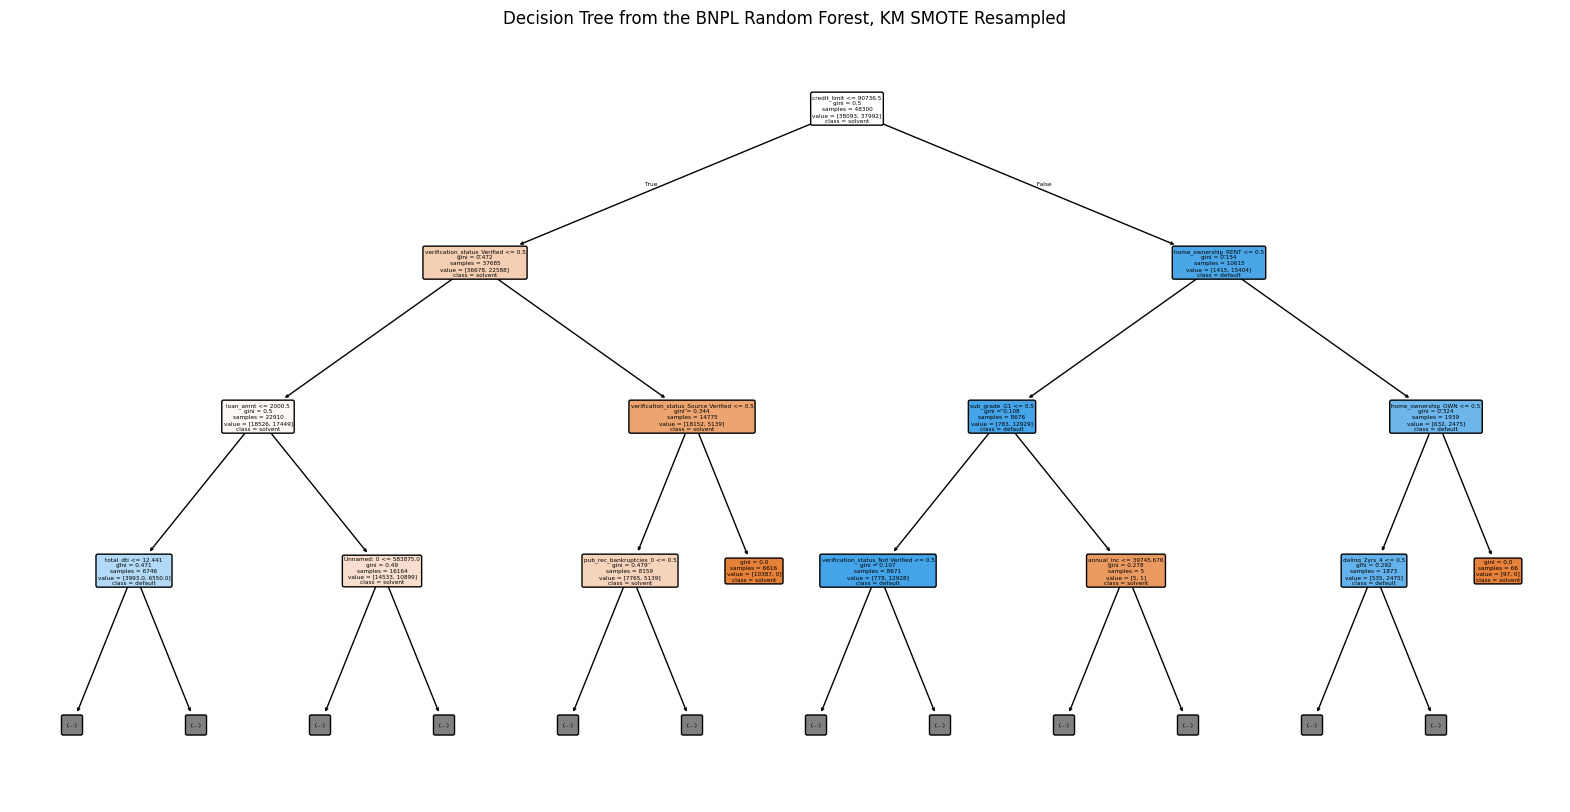

In [48]:
#Visualize a tree from the random forest to investigate splitting features

#plot the tree
tree_rf_km = bnpl_rf_km.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree_rf_km,
          feature_names=rf_features,
          class_names=rf_class_names,
          filled=True,
          rounded=True,
          max_depth = 3) #limit the depth so text can be read
plt.title("Decision Tree from the BNPL Random Forest, KM SMOTE Resampled")
plt.show()

In [49]:
tr.print_diff()

                                   types |   # objects |   total size
======================================== | =========== | ============
                                     str |      150994 |     11.02 MB
                                    list |        1422 |      1.29 MB
                                    dict |        2454 |      1.22 MB
                           numpy.ndarray |         750 |    406.62 KB
                                     set |         319 |    106.29 KB
                   weakref.ReferenceType |        1220 |     95.31 KB
                                   tuple |        1415 |     85.67 KB
              builtin_function_or_method |        1152 |     81.00 KB
                     function (<lambda>) |         453 |     67.24 KB
  matplotlib.font_manager.FontProperties |         354 |     19.36 KB
                         itertools.count |         309 |     16.90 KB
            matplotlib.cbook._UnhashDict |         307 |     16.79 KB
       matplotlib.cb

## Support Vector Machine

### Using SMOTE Resampled data

In [50]:
#initialize the model
#In this instance, we will operate on a linear approach to separation

bnpl_svm = LinearSVC(C = 10, random_state=55)

In [51]:
#scale the training data
scaler = MinMaxScaler()
bnpl_att_train_resample_scaled = scaler.fit_transform(bnpl_att_train_resample)

In [52]:
#cross validation of SVM
svm_cv_scores = cross_val_score(bnpl_svm, bnpl_att_train_resample_scaled, bnpl_tar_train_resample, cv= 5, scoring ="accuracy")

In [53]:
print("Cross-Validation Accuracy Scores on Training Set:", svm_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", svm_cv_scores.mean())

Cross-Validation Accuracy Scores on Training Set: [0.78338591 0.99986855 0.99940848 0.99993428 0.99967138]
Average Cross-Validation Accuracy on Training Set: 0.9564537182266241


In [54]:
#model training

#include a timer to track the execution
time_start = perf_counter()

#train the model on the training dataset
bnpl_svm.fit(bnpl_att_train_resample_scaled, bnpl_tar_train_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 6.511640914000054 seconds


In [55]:
#scale the test attributes
bnpl_test_att_scaled = scaler.fit_transform(bnpl_att_test)

#collect the predictions in a variable
tar_pred_test_svm = bnpl_svm.predict(bnpl_test_att_scaled)

#calculate the evaluation metrics
svm_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_svm)
svm_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_svm, pos_label='solvent')
svm_specificity = recall_score(bnpl_tar_test, tar_pred_test_svm, pos_label='default')
svm_f1 = f1_score(bnpl_tar_test, tar_pred_test_svm, pos_label = 'solvent')

#display the results
print("Test Accuracy:", svm_testaccuracy)
print("Sensitivity (Recall for Default):", svm_sensitivity)
print("Specificity (Recall for Solvent):", svm_specificity)
print("F1 Score:", svm_f1)

Test Accuracy: 0.9318694965003387
Sensitivity (Recall for Default): 0.9998162665360117
Specificity (Recall for Solvent): 0.13256484149855907
F1 Score: 0.9643500605487787


In [56]:
#calculate confusion matrix
svm_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_svm)

# Extract TP, FP, TN, FN from the confusion matrix
svm_tn, svm_fp, svm_fn, svm_tp = svm_conmatx.ravel()
print("True Negatives (TN):", svm_tn)
print("False Positives (FP):", svm_fp)
print("False Negatives (FN):", svm_fn)
print("True Positives (TP):", svm_tp)

True Negatives (TN): 184
False Positives (FP): 1204
False Negatives (FN): 3
True Positives (TP): 16325


<Axes: >

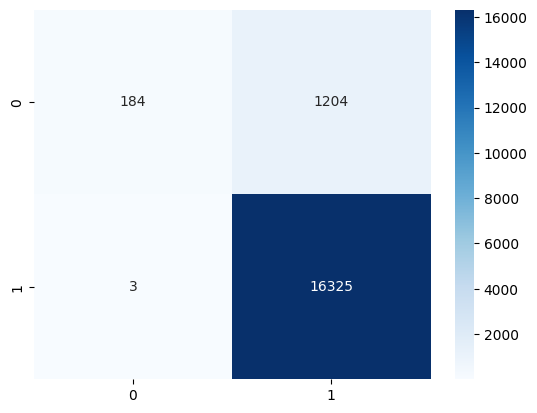

In [140]:
#display confusion matrix with seaborn
sns.heatmap(svm_conmatx, cmap = "Blues", annot=True, fmt='d')

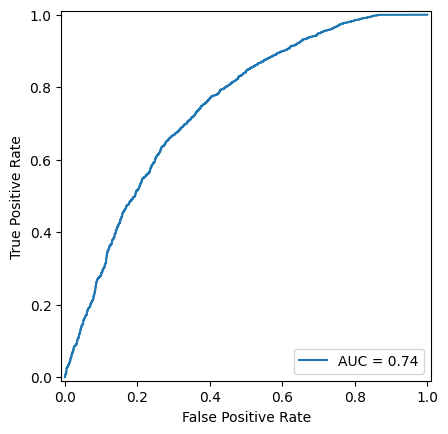

In [58]:
#calculate area under the curve
svm_fpr, svm_tpr, svm_threshold = roc_curve(bnpl_tar_test,
                                           (bnpl_svm.decision_function(bnpl_test_att_scaled)),
                                            pos_label='solvent'
                                            )

bnpl_svm_roc_auc = auc(svm_fpr, svm_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=svm_fpr, tpr=svm_tpr, roc_auc=bnpl_svm_roc_auc)
display.plot()

In [59]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                      numpy.ndarray |         328 |    299.88 KB
                               dict |        1008 |    275.96 KB
                               list |         691 |     42.20 KB
                                set |         155 |     33.20 KB
                function (<lambda>) |         177 |     26.27 KB
              weakref.ReferenceType |         171 |     13.36 KB
         builtin_function_or_method |         188 |     13.22 KB
                                str |         103 |     12.55 KB
                    itertools.count |         150 |      8.20 KB
       matplotlib.cbook._UnhashDict |         149 |      8.15 KB
  matplotlib.cbook.CallbackRegistry |         149 |      8.15 KB
          matplotlib.artist._XYPair |         144 |      7.88 KB
                             method |         102 |      6.38 KB
               matplotlib

### Using KMEans SMOTE Resampled data

In [60]:
#initialize the model
bnpl_svm_km = LinearSVC(C = 1, random_state=55)

In [61]:
#scale the training data
bnpl_att_train_km_resample_scaled = scaler.fit_transform(bnpl_att_train_km_resample)

In [62]:
#conduct cross validation
svm_cv_scores_km = cross_val_score(bnpl_svm_km, bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample, cv= 5, scoring ="accuracy")

print("Cross-Validation Accuracy Scores on Training Set:", svm_cv_scores_km)
print("Average Cross-Validation Accuracy on Training Set:", svm_cv_scores_km.mean())

Cross-Validation Accuracy Scores on Training Set: [0.7877374  0.99993428 0.99967142 0.99993428 0.99967142]
Average Cross-Validation Accuracy on Training Set: 0.9573897614510087


In [63]:
#train the model on the full dataset

#include a timer to track the execution
time_start = perf_counter()

#fit the model
bnpl_svm_km.fit(bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Took 5.334689926999999 seconds


In [64]:
#the scaled test variable is already created

#save the predictions in a variable
tar_pred_test_svm_km = bnpl_svm_km.predict(bnpl_test_att_scaled)

#calculate the evaluation metrics
svm_km_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_svm_km)
svm_km_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_svm_km, pos_label='solvent')
svm_km_specificity = recall_score(bnpl_tar_test, tar_pred_test_svm_km, pos_label='default')
svm_km_f1 = f1_score(bnpl_tar_test, tar_pred_test_svm_km, pos_label = 'solvent')

#print the results
print("Test Accuracy:", svm_km_testaccuracy)
print("Sensitivity (Recall for Solvent):", svm_km_sensitivity)
print("Specificity (Recall for Default):", svm_km_specificity)
print("F1 Score:", svm_km_f1)

Test Accuracy: 0.9318694965003387
Sensitivity (Recall for Solvent): 0.9998162665360117
Specificity (Recall for Default): 0.13256484149855907
F1 Score: 0.9643500605487787


In [65]:
#calculate the confusion matrix
svm_km_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_svm_km)

# Extract TP, FP, TN, FN from the confusion matrix
svm_km_tn, svm_km_fp, svm_km_fn, svm_km_tp = svm_km_conmatx.ravel()
print("True Negatives (TN):", svm_km_tn)
print("False Positives (FP):", svm_km_fp)
print("False Negatives (FN):", svm_km_fn)
print("True Positives (TP):", svm_km_tp)

True Negatives (TN): 184
False Positives (FP): 1204
False Negatives (FN): 3
True Positives (TP): 16325


<Axes: >

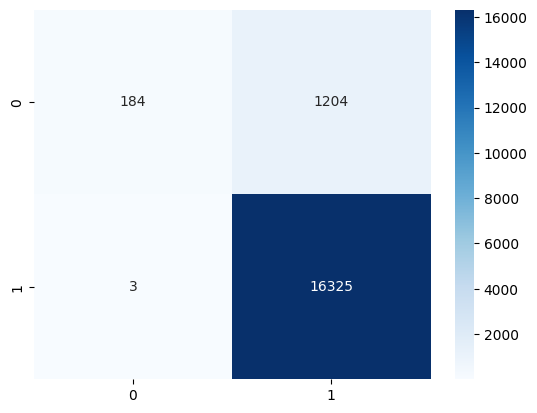

In [139]:
#display the heatmap
sns.heatmap(svm_km_conmatx, cmap = "Blues", annot=True, fmt='d')

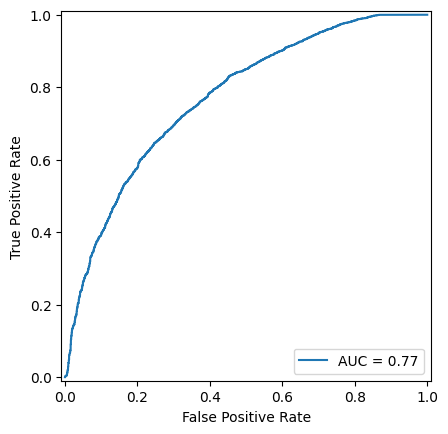

In [67]:
#calculate area under the curve
svm_km_fpr, svm_km_tpr, svm_km_threshold = roc_curve(bnpl_tar_test,
                                           (bnpl_svm_km.decision_function(bnpl_test_att_scaled)),
                                            pos_label='solvent'
                                            )

bnpl_svm_km_roc_auc = auc(svm_km_fpr, svm_km_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=svm_km_fpr, tpr=svm_km_tpr, roc_auc=bnpl_svm_km_roc_auc)
display.plot()

In [68]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |        2173 |    736.92 KB
                      numpy.ndarray |         766 |    382.96 KB
                               list |        1446 |     88.66 KB
                function (<lambda>) |         472 |     70.06 KB
                                set |         325 |     69.55 KB
                              tuple |         925 |     51.43 KB
              weakref.ReferenceType |         514 |     40.16 KB
         builtin_function_or_method |         474 |     33.33 KB
                    itertools.count |         315 |     17.23 KB
       matplotlib.cbook._UnhashDict |         313 |     17.12 KB
  matplotlib.cbook.CallbackRegistry |         313 |     17.12 KB
          matplotlib.artist._XYPair |         292 |     15.97 KB
                                str |         124 |     13.95 KB
                         

## LightGBM

### Using SMOTE Resampled data

In [69]:
#initialize the LightGBM model
bnpl_lgb = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=150,
    num_leaves=120,
    learning_rate=0.09,
    force_row_wise=True
)

In [70]:
#scale the training data
scaler = MinMaxScaler()
bnpl_att_train_resample_scaled = scaler.fit_transform(bnpl_att_train_resample)

In [71]:
#cross validation of LightGBM
lgb_cv_scores = cross_val_score(bnpl_lgb, bnpl_att_train_resample_scaled, bnpl_tar_train_resample, cv= 5, scoring ="accuracy")

[LightGBM] [Info] Number of positive: 30430, number of negative: 30430
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 60860, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30430, number of negative: 30431
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 60861, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499992 -> initscore=-0.000033
[LightGBM] [Info] Start training from score -0.000033


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30430, number of negative: 30431
[LightGBM] [Info] Total Bins 2966
[LightGBM] [Info] Number of data points in the train set: 60861, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499992 -> initscore=-0.000033
[LightGBM] [Info] Start training from score -0.000033


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30431, number of negative: 30430
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 60861, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30431, number of negative: 30430
[LightGBM] [Info] Total Bins 2962
[LightGBM] [Info] Number of data points in the train set: 60861, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [72]:
#print the results
print("Cross-Validation Accuracy Scores on Training Set:", lgb_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", lgb_cv_scores.mean())

Cross-Validation Accuracy Scores on Training Set: [0.80914826 0.99802826 0.99861978 0.99835688 0.99737102]
Average Cross-Validation Accuracy on Training Set: 0.9603048419551102


In [73]:
#train the model on the train dataset, resampled with SMOTE and target variables scaled

#add a timer for execution measurement
time_start = perf_counter()

bnpl_lgb.fit(bnpl_att_train_resample_scaled, bnpl_tar_train_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

[LightGBM] [Info] Number of positive: 38038, number of negative: 38038
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 76076, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Took 3.1274617279999575 seconds


In [74]:
#scale the test attributes
bnpl_test_att_scaled = scaler.fit_transform(bnpl_att_test)

#collect the predictions in a variable
tar_pred_test_lgb = bnpl_lgb.predict(bnpl_test_att_scaled)

#calcualte the evaluation metrics
lgb_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgb)
lgb_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgb, pos_label='solvent')
lgb_specificity = recall_score(bnpl_tar_test, tar_pred_test_lgb, pos_label='default')
lgb_f1 = f1_score(bnpl_tar_test, tar_pred_test_lgb, pos_label = 'solvent')

#print the results
print("Test Accuracy:", lgb_testaccuracy)
print("Sensitivity (Recall for Default):", lgb_sensitivity)
print("Specificity (Recall for Solvent):", lgb_specificity)
print("F1 Score:", lgb_f1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.9313614811469858
Sensitivity (Recall for Default): 0.9989588437040666
Specificity (Recall for Solvent): 0.1361671469740634
F1 Score: 0.9640640699804953


In [75]:
#calculate the confusion matrix
lgb_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_lgb)

# Extract TP, FP, TN, FN from the confusion matrix
lgb_tn, lgb_fp, lgb_fn, lgb_tp = lgb_conmatx.ravel()
print("True Negatives (TN):", lgb_tn)
print("False Positives (FP):", lgb_fp)
print("False Negatives (FN):", lgb_fn)
print("True Positives (TP):", lgb_tp)

True Negatives (TN): 189
False Positives (FP): 1199
False Negatives (FN): 17
True Positives (TP): 16311


<Axes: >

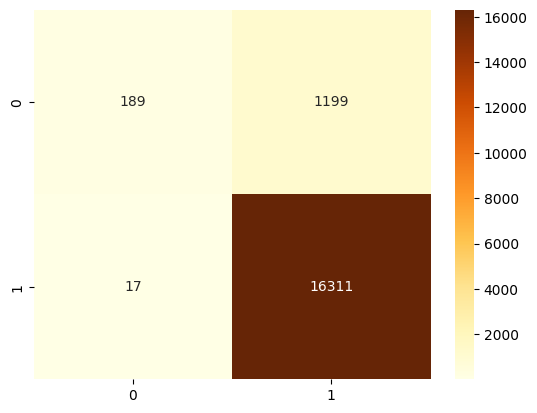

In [141]:
#display confusion matrix
sns.heatmap(lgb_conmatx, cmap = "YlOrBr", annot=True, fmt='d')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



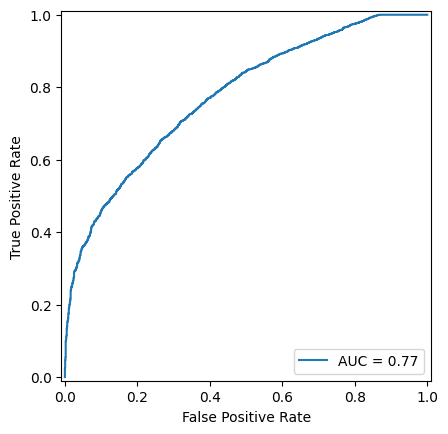

In [147]:
#calculate area under the curve
lgb_fpr, lgb_tpr, threshold = roc_curve(bnpl_tar_test, (bnpl_lgb.predict_proba(bnpl_test_att_scaled)[:, 1]), pos_label='solvent')

bnpl_lgb_roc_auc = auc(lgb_fpr, lgb_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=lgb_fpr, tpr=lgb_tpr, roc_auc=bnpl_lgb_roc_auc)
display.plot()

In [78]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |        2286 |    858.99 KB
                      numpy.ndarray |         767 |    384.07 KB
                                str |        2900 |    255.85 KB
                              tuple |        4230 |    250.38 KB
                               list |        1592 |    124.48 KB
                function (<lambda>) |         476 |     70.66 KB
                                set |         325 |     69.55 KB
              weakref.ReferenceType |         523 |     40.86 KB
         builtin_function_or_method |         485 |     34.10 KB
                    itertools.count |         315 |     17.23 KB
       matplotlib.cbook._UnhashDict |         313 |     17.12 KB
  matplotlib.cbook.CallbackRegistry |         313 |     17.12 KB
          matplotlib.artist._XYPair |         292 |     15.97 KB
                         

### using KMeans SMOTE Resampled data

In [79]:
#initialize LightGBM model
bnpl_lgb_km = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=150,
    num_leaves=120,
    learning_rate=0.09,
    force_row_wise=True
)

In [80]:
#scale the training data
bnpl_att_train_km_resample_scaled = scaler.fit_transform(bnpl_att_train_km_resample)

In [81]:
#conduct the cross validation
lgb_cv_scores_KM = cross_val_score(bnpl_lgb_km, bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample, cv= 5, scoring ="accuracy")

[LightGBM] [Info] Number of positive: 30430, number of negative: 30438
[LightGBM] [Info] Total Bins 2946
[LightGBM] [Info] Number of data points in the train set: 60868, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499934 -> initscore=-0.000263
[LightGBM] [Info] Start training from score -0.000263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30430, number of negative: 30438
[LightGBM] [Info] Total Bins 2946
[LightGBM] [Info] Number of data points in the train set: 60868, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499934 -> initscore=-0.000263
[LightGBM] [Info] Start training from score -0.000263


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30430, number of negative: 30438
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 60868, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499934 -> initscore=-0.000263
[LightGBM] [Info] Start training from score -0.000263


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30431, number of negative: 30437
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 60868, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499951 -> initscore=-0.000197
[LightGBM] [Info] Start training from score -0.000197


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 30431, number of negative: 30437
[LightGBM] [Info] Total Bins 2946
[LightGBM] [Info] Number of data points in the train set: 60868, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499951 -> initscore=-0.000197
[LightGBM] [Info] Start training from score -0.000197


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [82]:
#print cross validation results
print("Cross-Validation Accuracy Scores on Training Set:", lgb_cv_scores_KM)
print("Average Cross-Validation Accuracy on Training Set:", lgb_cv_scores_KM.mean())

Cross-Validation Accuracy Scores on Training Set: [0.78708024 0.99592561 0.99612276 0.99599133 0.99677992]
Average Cross-Validation Accuracy on Training Set: 0.9543799697706513


In [83]:
#train the model on the training dataset

#add a timer for execution measurement
time_start = perf_counter()

#fit the model
bnpl_lgb_km.fit(bnpl_att_train_km_resample_scaled, bnpl_tar_train_km_resample)

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

[LightGBM] [Info] Number of positive: 38038, number of negative: 38047
[LightGBM] [Info] Total Bins 2956
[LightGBM] [Info] Number of data points in the train set: 76085, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499941 -> initscore=-0.000237
[LightGBM] [Info] Start training from score -0.000237
Took 3.127913934999924 seconds


In [84]:
#the scaled variable is already created

#predict on the test data
tar_pred_test_lgb_km = bnpl_lgb_km.predict(bnpl_test_att_scaled)

#calculate the evaluation metrics
lgb_km_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgb_km)
lgb_km_sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgb_km, pos_label='solvent')
lgb_km_specificity = recall_score(bnpl_tar_test, tar_pred_test_lgb_km, pos_label='default')
lgb_km_f1 = f1_score(bnpl_tar_test, tar_pred_test_lgb_km, pos_label = 'solvent')

#print the results
print("Test Accuracy:", lgb_km_testaccuracy)
print("Sensitivity (Recall for Solvent):", lgb_km_sensitivity)
print("Specificity (Recall for Default):", lgb_km_specificity)
print("F1 Score:", lgb_km_f1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.9302325581395349
Sensitivity (Recall for Solvent): 0.9979176874081332
Specificity (Recall for Default): 0.1340057636887608
F1 Score: 0.9634578997161779


In [85]:
#calculate confusion matrix
lgb_km_conmatx = confusion_matrix(bnpl_tar_test, tar_pred_test_lgb_km)

#print TP, FP, TN, FN from the confusion matrix
lgb_km_tn, lgb_km_fp, lgb_km_fn, lgb_km_tp = lgb_km_conmatx.ravel()
print("True Negatives (TN):", lgb_km_tn)
print("False Positives (FP):", lgb_km_fp)
print("False Negatives (FN):", lgb_km_fn)
print("True Positives (TP):", lgb_km_tp)

True Negatives (TN): 186
False Positives (FP): 1202
False Negatives (FN): 34
True Positives (TP): 16294


<Axes: >

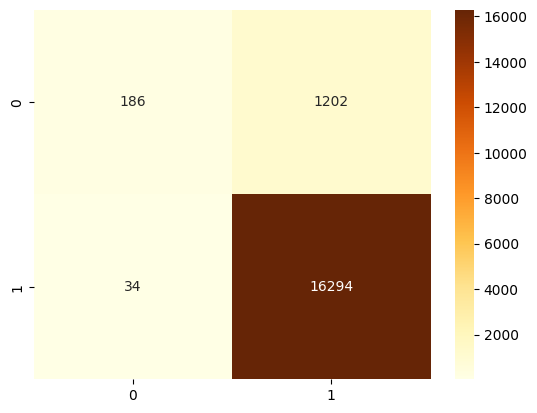

In [142]:
#display the confusion matrix
sns.heatmap(lgb_km_conmatx, cmap='YlOrBr', annot=True, fmt='d')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


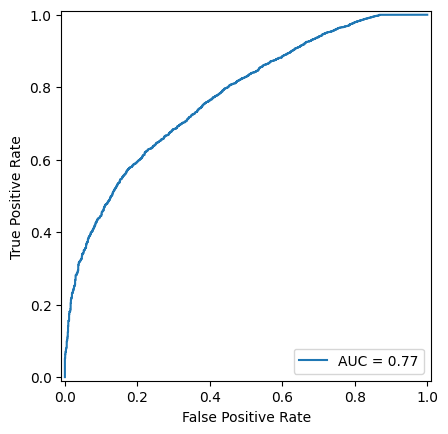

In [87]:
#Calculate area under the curve
lgb_km_fpr, lgb_km_tpr, lgb_km_threshold = roc_curve(bnpl_tar_test, (bnpl_lgb_km.predict_proba(bnpl_test_att_scaled)[:, 1]), pos_label='solvent')

bnpl_lgb_km_roc_auc = auc(lgb_km_fpr, lgb_km_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=lgb_km_fpr, tpr=lgb_km_tpr, roc_auc=bnpl_lgb_km_roc_auc)
display.plot()

In [88]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |        2179 |    737.88 KB
                      numpy.ndarray |         766 |    377.16 KB
                               list |        1453 |     88.66 KB
                function (<lambda>) |         475 |     70.51 KB
                                set |         325 |     69.55 KB
                              tuple |        1052 |     59.05 KB
              weakref.ReferenceType |         518 |     40.47 KB
         builtin_function_or_method |         480 |     33.75 KB
                    itertools.count |         315 |     17.23 KB
       matplotlib.cbook._UnhashDict |         313 |     17.12 KB
  matplotlib.cbook.CallbackRegistry |         313 |     17.12 KB
          matplotlib.artist._XYPair |         292 |     15.97 KB
                                str |         136 |     14.64 KB
                         

## Artificial Neural Network

### Using SMOTE Resampling

In [89]:
#define a function to quickly create hidden layers of a neural network

def create_hidden_layer(df, neural_network, max_layer, divisor=2):
  """
  a function to quickly program iterative hidden layers
  includes first hidden layer which takes into account number of input neurons
  interates backwards from max number of layers, going down by dividing by divisor
  df: pandas dataframe
  neural_network: the NN being constructed
  may_layer: the most layers you want, should be even number
  increment: number to divide by
  """
  num = max_layer
  i = 0
  while num >= 3:
    unit = int(num)
    if i == 0:
       hidden_layer_num = Dense(units=unit, activation="relu", input_shape=(df.shape[1],))
    else:
       hidden_layer_num = Dense(units=unit, activation="relu")
    neural_network.add(hidden_layer_num)
    num /= divisor
    i += 1


In [90]:
#develop the NN model

bnpl_nn = Sequential()

create_hidden_layer(bnpl_att_train_resample, bnpl_nn, 128, 4)

#initiate the final layer
output_layer = Dense(units=2, activation="softmax")
bnpl_nn.add(output_layer)

#print a summary
bnpl_nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,122 (156.73 KB)

 Trainable params: 40,122 (156.73 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
#scale the data for accuracy test, pre-training
scaler = MinMaxScaler()
bnpl_test_att_scaled = scaler.fit_transform(bnpl_att_test)

#encode the y_test data to labeled categorical for neural network accuracy_score functionality
y_test_encoded_pretraining = le().fit_transform(bnpl_tar_test)

In [92]:
#because the neural network outputs probabilities, convert the output values back into binary
tar_pred_probs = bnpl_nn.predict(bnpl_test_att_scaled)
tar_pred = np.argmax(tar_pred_probs, axis=1)

#test the accuracy of the neural network without training
accuracy_score(y_test_encoded_pretraining, tar_pred)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


0.5479792278166629

###Performing Cross Validation on a Neural Network
As seen in the other models, thanks to SciKit Learn, cross validation can easily be done with the built-in function cross_val_scores. However, cross_val_score does not work automatically on a Keras neural network, so we will create a loop to manually calculate cv scores

In [93]:
#first create a function to develop fresh neural network models
def create_nn_model(input_df, max_layer=128, divisor=4, num_classes=2):
    """
    A function to quickly make a neural network. Initiates model within function, develops and adds
    input and hidden layer, develops output layer, adds loss function, and compiles, returning fresh neural network
    Relies on function create_hidden_layer
    input_df: pandas dataframe
    may_layer: the most layers you want, should be even number
    divisor: number to divide by
    num_classes: the number of classes to be categorized, default to binary classification of 2
    """
    nn_model = Sequential()

    #develop input and hidden layers via defined function
    create_hidden_layer(input_df, nn_model, max_layer, divisor)

    #create output layer
    nn_model.add(Dense(units=num_classes, activation='softmax'))
    loss_fn = 'categorical_crossentropy'

    # Compile the model
    nn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    return nn_model

In [94]:
#initialize the kFolds

nn_kf = KFold(n_splits=5, shuffle=True, random_state= 55)

In [95]:
#run a for loop to collect cross validation across 5 folds, collect in a list
nn_cv_scores = []

for train_index, val_index in nn_kf.split(bnpl_att_train_resample):
    y_fold_encoded = le().fit_transform(bnpl_tar_train_resample)
    X_train, X_val = bnpl_att_train_resample.iloc[train_index], bnpl_att_train_resample.iloc[val_index]
    y_train, y_val = to_categorical(y_fold_encoded[train_index].astype('int'), num_classes=2), to_categorical(y_fold_encoded[val_index].astype('int'), num_classes=2)

    #create new instance of nn model inside loop
    model = create_nn_model(bnpl_att_train_resample, 128, 4)

    #fit model
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    #extract predictions and account for one-hot encoding
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    #calculate accuracy of the loop
    nn_fold_score = accuracy_score(y_val_true, y_pred)
    nn_cv_scores.append(nn_fold_score)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [96]:
#print results
print("Cross-Validation Accuracy Scores on Training Set:", nn_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", sum(nn_cv_scores) / 5)

Cross-Validation Accuracy Scores on Training Set: [0.5843848580441641, 0.4965494577719356, 0.5477489319750246, 0.49799539927702924, 0.49786395004929346]
Average Cross-Validation Accuracy on Training Set: 0.5249085194234894


In [97]:
tr.print_diff()

                                                                 types |   # objects |   total size
====================================================================== | =========== | ============
                                           pandas.core.frame.DataFrame |           2 |     25.83 MB
                                                                  dict |       25244 |      4.05 MB
                                                         numpy.ndarray |         572 |      2.46 MB
                                                                  list |       17441 |      1.28 MB
                                                                   str |        9372 |    775.05 KB
                                                                   set |        1656 |    702.31 KB
                        tensorflow.python.framework.ops.SymbolicTensor |        6154 |    673.09 KB
                                        pandas.core.indexes.base.Index |           2 |    594.41 KB


###Continuing onto training of the neural network for our model

In [98]:
#compile the network to get it ready for training
bnpl_nn.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer = 'adam')

In [99]:
#incase we want to reset the weight, we'll save them into this variable for future use
initial_weights = bnpl_nn.get_weights()

In [100]:
#we'll enact a callback with an early_stop since running many epochs is high computational time
#if we don't see loss improvement after 5 epochs, the code will restore best weights to avoid overfitting

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [101]:
#encode the y_train variable
y_train_encoded = to_categorical(le().fit_transform(bnpl_tar_train_resample), num_classes=2)

In [102]:
#scale the training data
bnpl_att_train_resample_scaled = scaler.fit_transform(bnpl_att_train_resample)

In [103]:
#train the data with x_train SMOTE resample
#we'll add validation_split so keras can evaluate model metrics after each epoch

#we'll also add a timer for the execution
time_start = perf_counter()

bnpl_nn.fit(bnpl_att_train_resample_scaled,
            y_train_encoded,
            epochs=10,
            batch_size = 32,
            validation_split=0.2,
            callbacks=early_stop
            )

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Epoch 1/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9141 - loss: 0.2432 - val_accuracy: 0.9995 - val_loss: 0.0023
Epoch 2/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9532 - loss: 0.1559 - val_accuracy: 0.9995 - val_loss: 9.5256e-04
Epoch 3/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9516 - loss: 0.1552 - val_accuracy: 0.9997 - val_loss: 5.5614e-04
Epoch 4/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9513 - loss: 0.1528 - val_accuracy: 0.9998 - val_loss: 4.8416e-04
Epoch 5/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9532 - loss: 0.1449 - val_accuracy: 0.9999 - val_loss: 5.1423e-04
Epoch 6/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9523 - loss: 0.1401 - val_accuracy: 0.9996 - val_loss: 6.6515e-04
Epoch 7/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9534 - loss: 0.1350 - val_accuracy: 0.9995 - val_loss: 0.0013
Epoch 8/10
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9

In [104]:
#encode again for post training
y_test_encoded_posttraining = to_categorical(le().fit_transform(bnpl_tar_test), num_classes = 2)

#check the accuracy post training
nn_accuracy = bnpl_nn.evaluate(bnpl_att_test, y_test_encoded_posttraining)
print('Training accuracy: {}%'.format(nn_accuracy[1]*100))

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5955 - loss: 34026.5586
Training accuracy: 59.25716757774353%


In [105]:
#calculate recall and precision

y_true = np.argmax(y_test_encoded_posttraining, axis=1)
y_pred_probs = bnpl_nn.predict(bnpl_att_test)
y_pred = np.argmax(y_pred_probs, axis=1)

nn_sensitivity = recall_score(y_true, y_pred, pos_label=1, average='binary')
nn_specificity = recall_score(y_true, y_pred, pos_label=0, average='binary')
nn_f1 = f1_score(y_true, y_pred, pos_label = 1)

print("Sensitivity (Recall for Default):", nn_sensitivity)
print("Specificity (Recall for Solvent):", nn_specificity)
print("F1 Score:", nn_f1)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Sensitivity (Recall for Default): 0.5848848603625674
Specificity (Recall for Solvent): 0.6829971181556196
F1 Score: 0.7257390379208146


In [106]:
#create a confusion matrix to validate recall, precision

#save true targets in a variable
tar_true = np.argmax(y_test_encoded_posttraining, axis=1)

#print confusion matrix
nn_conmatx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", nn_conmatx)

Confusion Matrix:
 [[ 948  440]
 [6778 9550]]


In [107]:
#extract confusion matrix values and print for clarity
nn_tn, nn_fp, nn_fn, nn_tp = nn_conmatx.ravel()
print("True Negatives (TN):", nn_tn)
print("False Positives (FP):", nn_fp)
print("False Negatives (FN):", nn_fn)
print("True Positives (TP):", nn_tp)

True Negatives (TN): 948
False Positives (FP): 440
False Negatives (FN): 6778
True Positives (TP): 9550


<Axes: >

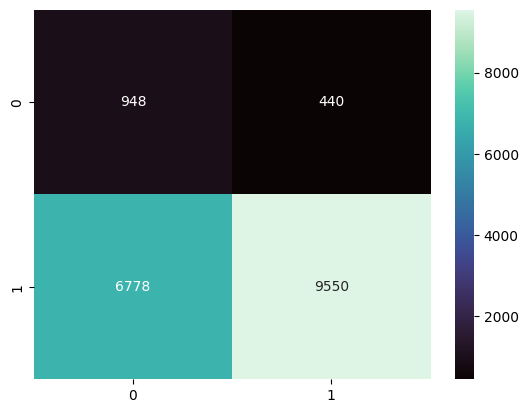

In [145]:
#visualize confusion matrix with seaborn heatmap
sns.heatmap(nn_conmatx, annot=True, fmt='d', cmap='mako')

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


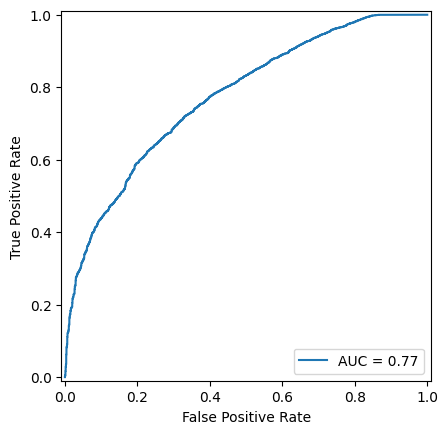

In [109]:
#calculate area under the curve
nn_fpr, nn_tpr, nn_threshold = roc_curve(bnpl_tar_test, bnpl_nn.predict(bnpl_test_att_scaled)[:, 1], pos_label='solvent')

bnpl_nn_roc_auc = auc(nn_fpr, nn_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=nn_fpr, tpr=nn_tpr, roc_auc=bnpl_nn_roc_auc)
display.plot()

In [110]:
tr.print_diff()

                                                                 types |   # objects |   total size
====================================================================== | =========== | ============
                                             pandas.core.series.Series |         556 |    186.62 MB
                                                                  dict |       10055 |      1.93 MB
                                                         numpy.ndarray |        1300 |      1.02 MB
                                                                  list |        5582 |    388.38 KB
                                                                 tuple |        4822 |    260.84 KB
                                                                   str |        1974 |    164.30 KB
                        tensorflow.python.framework.ops.SymbolicTensor |        1347 |    147.33 KB
                                                 weakref.ReferenceType |        1754 |    137.03 KB


### Using KMeans SMOTE Resampling

In [111]:
#develop the NN model with kMEans Smote

bnpl_nn_km = Sequential()

create_hidden_layer(bnpl_att_train_km_resample, bnpl_nn_km, 128, 4)

#initiate the final layer
output_layer = Dense(units=2, activation="softmax")
bnpl_nn_km.add(output_layer)

#print a summary
bnpl_nn_km.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │        35,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,122 (156.73 KB)

 Trainable params: 40,122 (156.73 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
#scaling data for accuracy test occured in SMOTE resampling

#encode the y_test data to labeled categorical for neural network accuracy_score functionality
y_test_encoded_pretraining_km = le().fit_transform(bnpl_tar_test)

In [113]:
#convert the output values back into binary
km_tar_pred_probs = bnpl_nn_km.predict(bnpl_test_att_scaled)
km_tar_pred = (km_tar_pred_probs[:,1] > 0.5).astype(int).flatten()

#test the accuracy of the neural network without training
accuracy_score(y_test_encoded_pretraining_km, km_tar_pred)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.9036464213140664

### Performing Cross Validation on a Neural Network, KM SMOTE

In [114]:
#the function to create fresh neural network models, as well as the kfolds variable is already created

#run the for loop for the KMeans SMOTE data
nn_km_cv_scores = []

for train_index, val_index in nn_kf.split(bnpl_att_train_km_resample):
    y_fold_encoded = le().fit_transform(bnpl_tar_train_km_resample)
    X_train, X_val = bnpl_att_train_km_resample.iloc[train_index], bnpl_att_train_km_resample.iloc[val_index]
    y_train, y_val = to_categorical(y_fold_encoded[train_index].astype('int'), num_classes=2), to_categorical(y_fold_encoded[val_index].astype('int'), num_classes=2)

    #create new instance of nn model inside loop
    model = create_nn_model(bnpl_att_train_km_resample, 128, 4)

    #fit model
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

    #extract predictions and account for one-hot encoding
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    #calculate accuracy of the loop
    nn_km_fold_score = accuracy_score(y_val_true, y_pred)
    nn_km_cv_scores.append(nn_km_fold_score)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [115]:
#print results
print("Cross-Validation Accuracy Scores on Training Set:", nn_km_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", sum(nn_km_cv_scores) / 5)

Cross-Validation Accuracy Scores on Training Set: [0.5911809160806992, 0.4939869882368404, 0.498849970427811, 0.6439508444502858, 0.5022014851810475]
Average Cross-Validation Accuracy on Training Set: 0.5460340408753368


In [116]:
tr.print_diff()

                                                                 types |   # objects |   total size
====================================================================== | =========== | ============
                                                                  dict |       20190 |      2.92 MB
                                                                  list |       15529 |      1.11 MB
                        tensorflow.python.framework.ops.SymbolicTensor |        6020 |    658.44 KB
                                                                   str |        7571 |    618.34 KB
                             tensorflow.python.framework.ops.Operation |        6342 |    495.47 KB
                                                         numpy.ndarray |        -553 |    335.45 KB
                 tensorflow.python.client._pywrap_tf_session.TF_Output |        6020 |    329.22 KB
                                               collections.OrderedDict |        1186 |    313.38 KB


### Continue onto training

In [117]:
#compile the network to get it ready for training
bnpl_nn_km.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer = 'adam')

In [118]:
#save the initial weights for preserverance
km_initial_weights = bnpl_nn_km.get_weights()

In [119]:
#encode the y_train variable
km_y_train_encoded = to_categorical(le().fit_transform(bnpl_tar_train_km_resample), num_classes=2)

In [120]:
#train the data with x_train KMSMOTE resample

#add a timer for the execution
time_start = perf_counter()

bnpl_nn_km.fit(bnpl_att_train_km_resample,
               km_y_train_encoded,
               epochs=10,
               batch_size = 32,
               validation_split = 0.2,
               callbacks=early_stop
               )

time_end = perf_counter()

# calculate the duration
time_duration = time_end - time_start
# report the duration
print(f'Took {time_duration} seconds')

Epoch 1/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5895 - loss: 52.9050 - val_accuracy: 0.0000e+00 - val_loss: 0.7140
Epoch 2/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6534 - loss: 0.5772 - val_accuracy: 0.9989 - val_loss: 0.6936
Epoch 3/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6399 - loss: 0.6140 - val_accuracy: 0.0000e+00 - val_loss: 0.9322
Epoch 4/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6276 - loss: 0.7117 - val_accuracy: 0.0000e+00 - val_loss: 0.9740
Epoch 5/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6268 - loss: 0.6606 - val_accuracy: 0.0000e+00 - val_loss: 0.9771
Epoch 6/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6221 - loss: 0.6631 - val_accuracy: 0.0000e+00 - val_loss: 0.9762
Epoch 7/10
1903/1903 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6233 - loss: 0.6625 - val_accuracy: 0.0000e+00 - val_loss: 0.9745
Took 68.99926747800009 seconds


In [121]:
#encode again for post training
y_test_encoded_posttraining_km = to_categorical(le().fit_transform(bnpl_tar_test), num_classes = 2)

#check the accuracy post training
nn_km_accuracy = bnpl_nn_km.evaluate(bnpl_att_test, y_test_encoded_posttraining_km)
print('Training accuracy: {}%'.format(nn_km_accuracy[1]*100))

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4526 - loss: 0.5910
Training accuracy: 45.19643187522888%


In [122]:
#calculate recall and precision

y_true_km = np.argmax(y_test_encoded_posttraining_km, axis=1)
y_pred_probs_km = bnpl_nn.predict(bnpl_att_test)
y_pred_km = np.argmax(y_pred_probs_km, axis=1)

nn_km_sensitivity = recall_score(y_true_km, y_pred_km, pos_label=1, average='binary')
nn_km_specificity = recall_score(y_true_km, y_pred_km, pos_label=0, average='binary')
nn_km_f1 = f1_score(y_true_km, y_pred_km, pos_label = 1)

print("Sensitivity (Recall for Default):", nn_km_sensitivity)
print("Specificity (Recall for Solvent):", nn_km_specificity)
print("F1 Score:", nn_km_f1)

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Sensitivity (Recall for Default): 0.5848848603625674
Specificity (Recall for Solvent): 0.6829971181556196
F1 Score: 0.7257390379208146


In [123]:
#create a confusion matrix to validate recall, precision

#save true targets in a variable
km_tar_true = np.argmax(y_test_encoded_posttraining_km, axis=1)

#print confusion matrix
nn_km_conmatx = confusion_matrix(km_tar_true, y_pred_km)
print("Confusion Matrix:\n", nn_km_conmatx)

Confusion Matrix:
 [[ 948  440]
 [6778 9550]]


In [124]:
#extract confusion matrix values and print for clarity
nn_tn_km, nn_fp_km, nn_fn_km, nn_tp_km = nn_km_conmatx.ravel()
print("True Negatives (TN):", nn_tn_km)
print("False Positives (FP):", nn_fp_km)
print("False Negatives (FN):", nn_fn_km)
print("True Positives (TP):", nn_tp_km)

True Negatives (TN): 948
False Positives (FP): 440
False Negatives (FN): 6778
True Positives (TP): 9550


<Axes: >

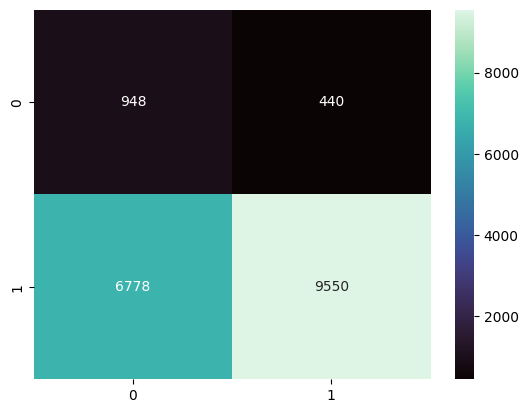

In [144]:
#visualize confusion matrix with seaborn heatmap
sns.heatmap(nn_km_conmatx, cmap="mako", annot=True, fmt='d')

554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


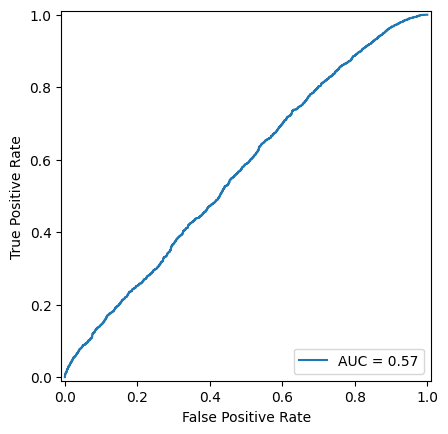

In [126]:
#calculate area under the curve
nn_km_fpr, nn_km_tpr, nn_km_threshold = roc_curve(bnpl_tar_test, bnpl_nn_km.predict(bnpl_test_att_scaled)[:, 1], pos_label='solvent')

bnpl_nn_km_roc_auc = auc(nn_km_fpr, nn_km_tpr)

#display AUC curve plot
display = RocCurveDisplay(fpr=nn_km_fpr, tpr=nn_km_tpr, roc_auc=bnpl_nn_km_roc_auc)
display.plot()

In [127]:
tr.print_diff()

                                                                 types |   # objects |   total size
====================================================================== | =========== | ============
                                             pandas.core.series.Series |         556 |    186.64 MB
                                                                  dict |       10238 |      1.99 MB
                                                         numpy.ndarray |        1294 |      1.01 MB
                                                                  list |        5579 |    387.93 KB
                                                                 tuple |        4018 |    212.77 KB
                                                                   str |        1886 |    156.03 KB
                        tensorflow.python.framework.ops.SymbolicTensor |        1384 |    151.38 KB
                                                 weakref.ReferenceType |        1752 |    136.88 KB


#Comparing all evaluation metrics

With all the models developed and evaluation metrics calculated, we'll now compare evaluation metrics across the 5 models.

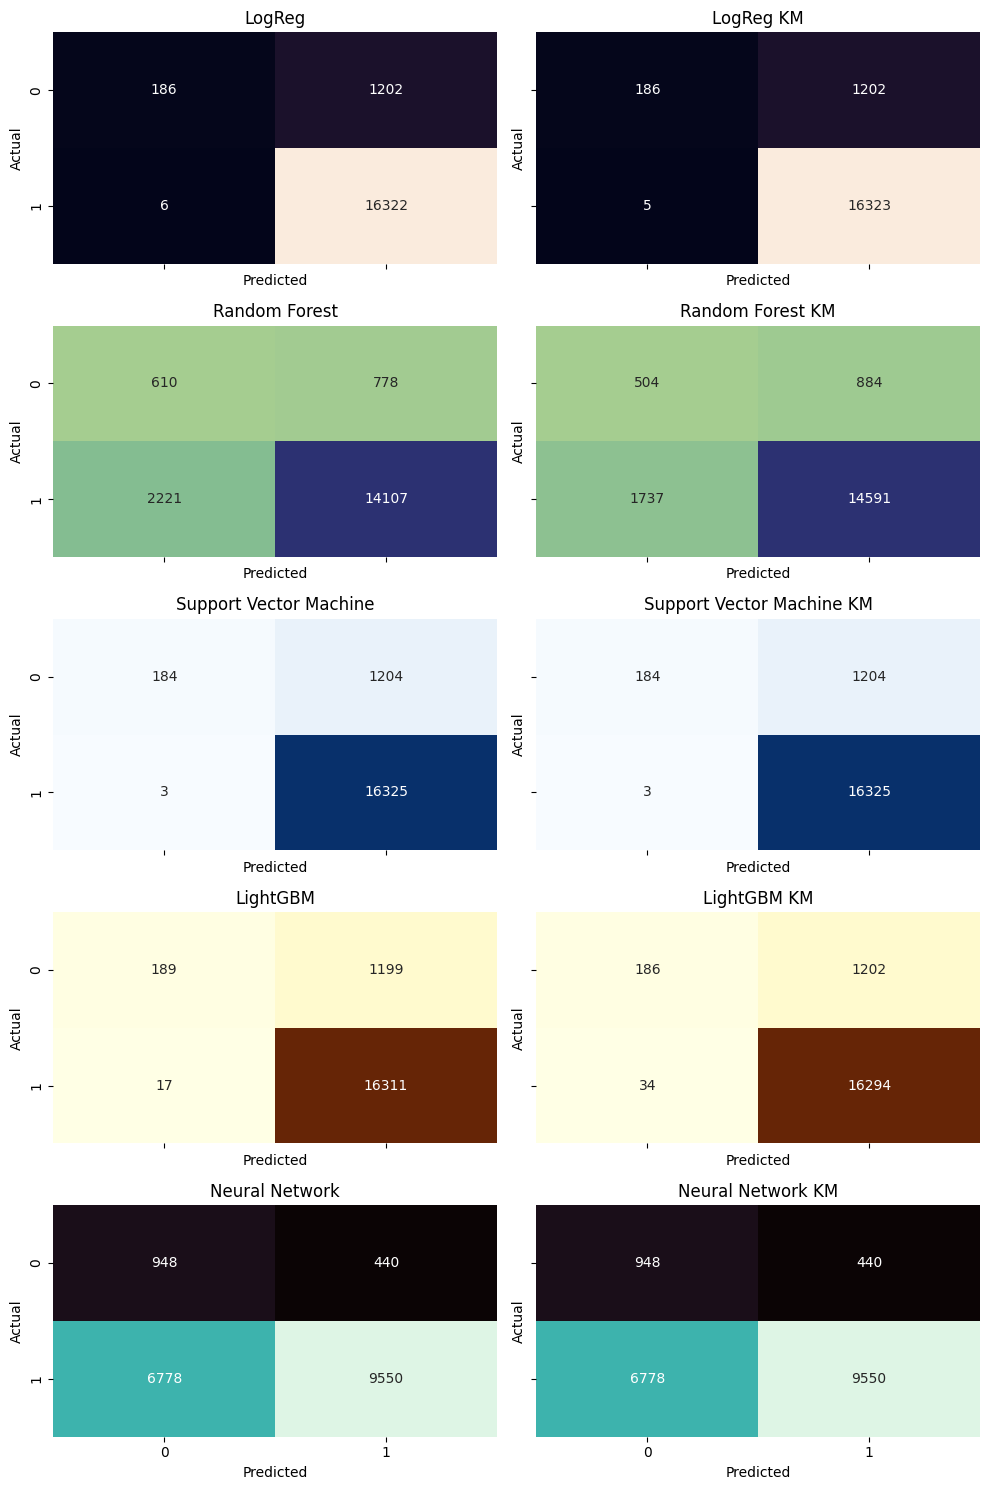

In [128]:
confusion_matrixes = [lgrg_conmatx, lgrg_km_conmatx,
                      rf_conmatx, rf_km_conmatx,
                      svm_conmatx, svm_km_conmatx,
                      lgb_conmatx, lgb_km_conmatx,
                      nn_conmatx, nn_km_conmatx
                      ]
conmatx_titles = ['LogReg', 'LogReg KM',
                  'Random Forest', 'Random Forest KM',
                  'Support Vector Machine', 'Support Vector Machine KM',
                  'LightGBM', 'LightGBM KM',
                  'Neural Network', 'Neural Network KM'
                  ]
conmatx_cmap = ['rocket', 'rocket',
                'crest', 'crest',
                'Blues', 'Blues',
                'YlOrBr','YlOrBr',
                'mako', 'mako']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=True)

axes = axes.flatten()

for i, (cm, ax) in enumerate(zip(confusion_matrixes, axes)):
    sns.heatmap(cm, cmap=conmatx_cmap[i], ax=ax, cbar=False, annot=True, fmt='d')
    ax.set_title(conmatx_titles[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [129]:
#gather the evaluation metrics into one dataframe

#create a dictionary
bnpl_eval_metrics = {
    'Model': ['Logistic Regression','Logistic Regression',
              'Random Forest','Random Forest',
              'Support Vector Machine','Support Vector Machine',
              'LightGBM','LightGBM',
              'Neural Network', 'Neural Network'
              ],
    'Resampling Method':['SMOTE','KM SMOTE',
                         'SMOTE','KM SMOTE',
                         'SMOTE','KM SMOTE',
                         'SMOTE','KM SMOTE',
                         'SMOTE','KM SMOTE'
                         ],
    'Accuracy': [lgrg_testaccuracy, lgrg_km_testaccuracy,
                 rf_accuracy, rf_km_accuracy,
                 svm_testaccuracy, svm_km_testaccuracy,
                 lgb_testaccuracy, lgb_km_testaccuracy,
                 nn_accuracy[1], nn_km_accuracy[1]
                 ],
    'Recall for Default':[lgrg_sensitivity, lgrg_km_sensitivity,
                          rf_sensitivity, rf_km_sensitivity,
                          svm_sensitivity, svm_km_sensitivity,
                          lgb_sensitivity, lgb_km_sensitivity,
                          nn_sensitivity, nn_km_sensitivity
                          ],
    'Recall for Solvent': [lgrg_specificity, lgrg_km_specificity,
                           rf_specificity, rf_km_specificity,
                           svm_specificity, svm_km_specificity,
                           lgb_specificity, lgb_km_specificity,
                           nn_specificity, nn_km_specificity
                           ],
    'F1 Score': [lgrg_f1, lgrg_km_f1,
                 rf_f1, rf_km_f1,
                 svm_f1, svm_km_f1,
                 lgb_f1, lgb_km_f1,
                 nn_f1, nn_km_f1
                 ],
    'AUC value': [bnpl_lgrg_roc_auc, bnpl_lgrg_km_roc_auc,
                  bnpl_rf_roc_auc, bnpl_rf_km_roc_auc,
                  bnpl_svm_roc_auc, bnpl_svm_km_roc_auc,
                  bnpl_lgb_roc_auc, bnpl_lgb_km_roc_auc,
                  bnpl_nn_roc_auc, bnpl_nn_km_roc_auc
                  ],
}

#convert to Dataframe
bnpl_eval_metrics_df = pd.DataFrame(bnpl_eval_metrics)

In [130]:
#inspect the contents of the dataframe to confirm
bnpl_eval_metrics_df

,Model,Resampling Method,Accuracy,Recall for Default,Recall for Solvent,F1 Score,AUC value
0,Logistic Regression,SMOTE,0.931813,0.999633,0.134006,0.964315,0.773101
1,Logistic Regression,KM SMOTE,0.931869,0.999694,0.134006,0.964346,0.773669
2,Random Forest,SMOTE,0.830718,0.863976,0.439481,0.903918,0.770691
3,Random Forest,KM SMOTE,0.852055,0.893618,0.363112,0.917586,0.711132
4,Support Vector Machine,SMOTE,0.931869,0.999816,0.132565,0.964350,0.744472
5,Support Vector Machine,KM SMOTE,0.931869,0.999816,0.132565,0.964350,0.770084
6,LightGBM,SMOTE,0.931361,0.998959,0.136167,0.964064,0.774851
7,LightGBM,KM SMOTE,0.930233,0.997918,0.134006,0.963458,0.773554
8,Neural Network,SMOTE,0.592572,0.584885,0.682997,0.725739,0.771692
9,Neural Network,KM SMOTE,0.451964,0.584885,0.682997,0.725739,0.569273


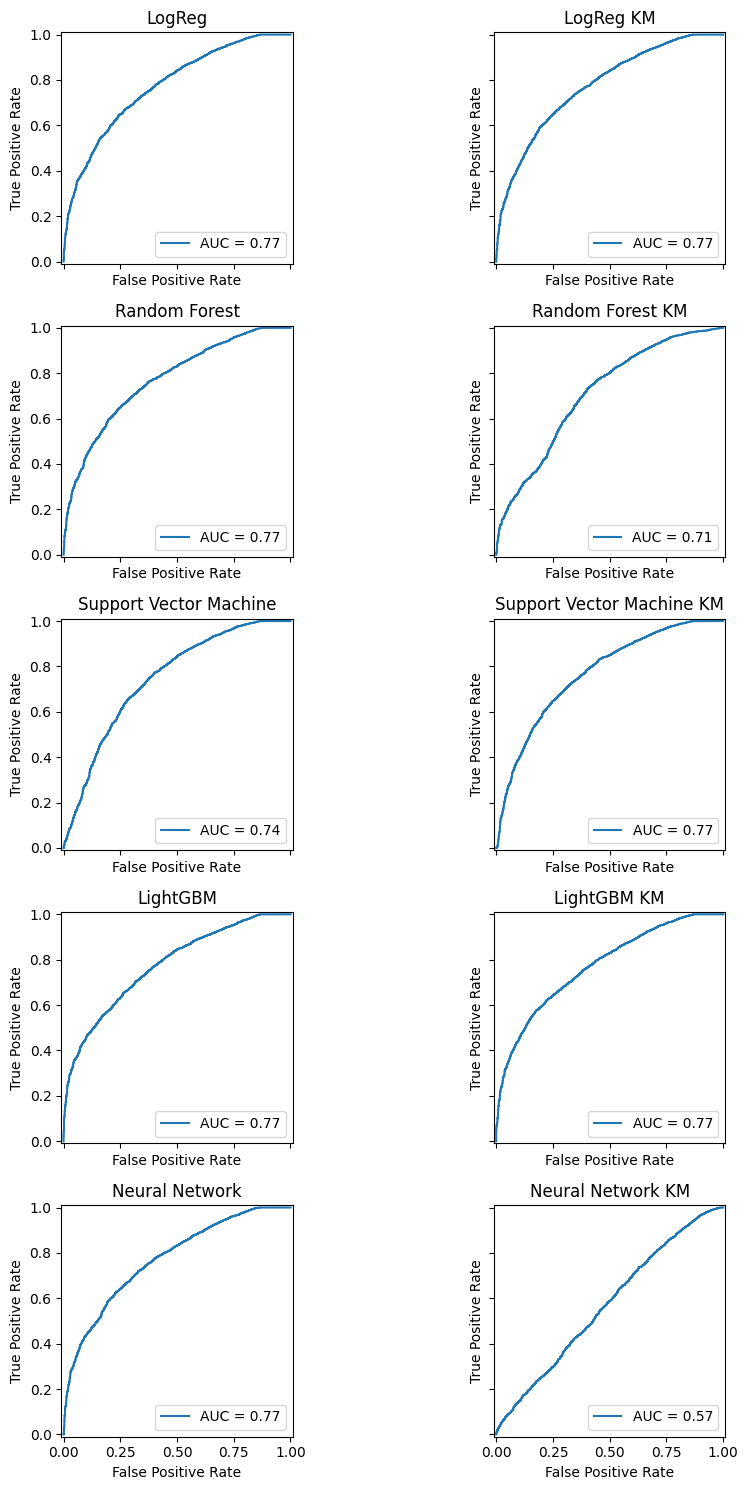

In [155]:
#gather all the AUC Curves and display them

AUC_Curves = [bnpl_lgrg_roc_auc, bnpl_lgrg_km_roc_auc,
                      bnpl_rf_roc_auc, bnpl_rf_km_roc_auc,
                      bnpl_svm_roc_auc, bnpl_svm_km_roc_auc,
                      bnpl_lgb_roc_auc, bnpl_lgb_km_roc_auc,
                      bnpl_nn_roc_auc, bnpl_nn_km_roc_auc
                      ]
AUCCurve_titles = ['LogReg', 'LogReg KM',
                  'Random Forest', 'Random Forest KM',
                  'Support Vector Machine', 'Support Vector Machine KM',
                  'LightGBM', 'LightGBM KM',
                  'Neural Network', 'Neural Network KM'
                  ]
fpr_list = [lgrg_fpr, lgrg_km_fpr,
            rf_fpr, rf_km_fpr,
            svm_fpr, svm_km_fpr,
            lgb_fpr, lgb_km_fpr,
            nn_fpr, nn_km_fpr
            ]

tpr_list = [lgrg_tpr, lgrg_km_tpr,
            rf_tpr, rf_km_tpr,
            svm_tpr, svm_km_tpr,
            lgb_tpr, lgb_km_tpr,
            nn_tpr, nn_km_tpr
            ]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True, sharey=True)

axes = axes.flatten()

for i, (auc_c, fpr, tpr, ax) in enumerate(zip(AUC_Curves,fpr_list,tpr_list, axes)):
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_c)
    display.plot(ax=ax)
    ax.set_title(AUCCurve_titles[i])
    #ax.set_xlabel('Predicted')
    #ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

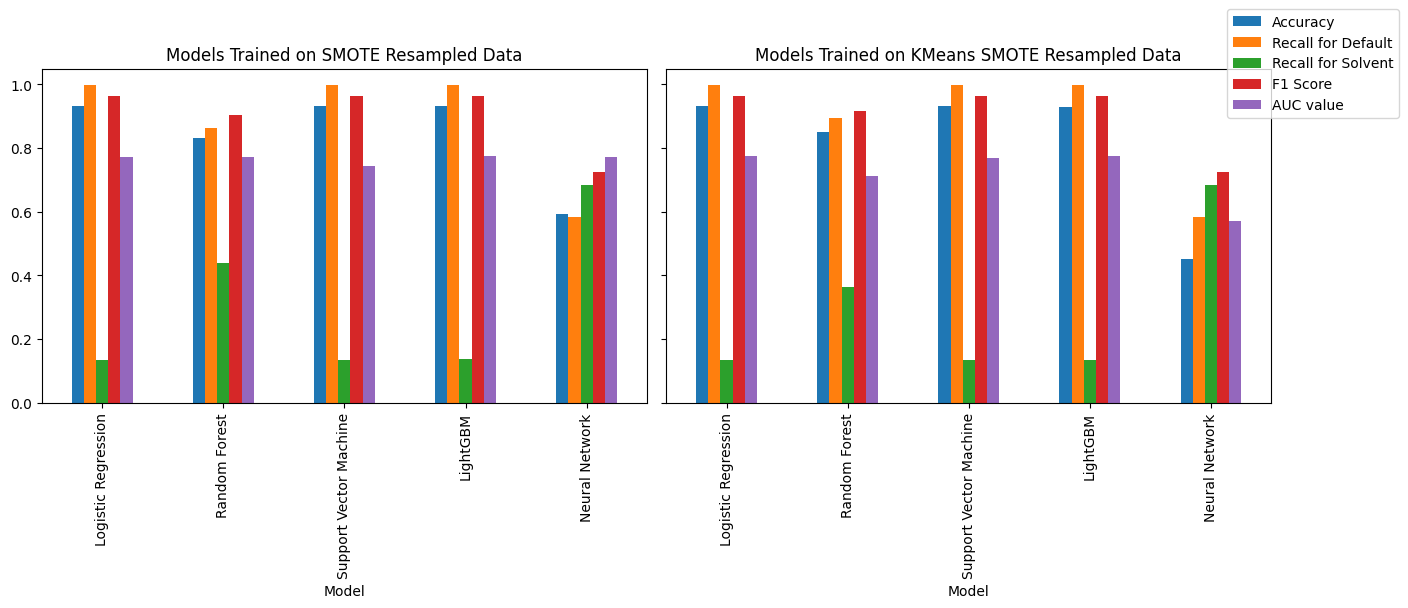

In [131]:
#using matplotlib and built in pandas methods, we can display a grouped bar plot of the evaluation metrics

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, layout='constrained')

for ax, (name, group) in zip(axes, bnpl_eval_metrics_df.groupby('Resampling Method', sort=False)):
    group.plot.bar(x='Model', ax=ax, title=name, legend=False)

#move the legend so values aren't blocked
ax.legend(bbox_to_anchor=(1, 1),
          bbox_transform=fig.transFigure)

#set titles
axes[0].set_title('Models Trained on SMOTE Resampled Data')
axes[1].set_title('Models Trained on KMeans SMOTE Resampled Data')

plt.show()

We'll use a radar chart to show how the models compare to each other on each evaluation metric. The plots are split by Resampling Method

In [161]:
#the plotly package is ideal for this data, because it's interactivity will allow us to display
#models that are hidden behind each other due to the similiarity in results

#collect the model names in a variable
metrics = bnpl_eval_metrics_df.columns[2:]

#make the figure object to hold the two plots via subplot
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
                    subplot_titles=['SMOTE Resampling','KMeans SMOTE Resampling'])

#a for loop will develop the plot for each model within the resampling method
#first SMOTE data
for i, row in bnpl_eval_metrics_df[bnpl_eval_metrics_df['Resampling Method'] == 'SMOTE'].iterrows():
  fig.add_trace(go.Scatterpolar(
      r=row[metrics].values,
      theta=metrics,
      fill='toself',
      name=row['Model'],
      legendgroup = row['Model']
  ), row=1, col=1)

#then KMeans SMOTE data
for i, row in bnpl_eval_metrics_df[bnpl_eval_metrics_df['Resampling Method']=='KM SMOTE'].iterrows():
  fig.add_trace(go.Scatterpolar(
      r=row[metrics].values,
      theta=metrics,
      fill='toself',
      name=row['Model'],
      legendgroup = row['Model'],
  ), row=1, col=2)

#adjust the size of the subplots and include the legend
fig.update_layout(
  height=700, width=1100,
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
)

fig.show()

#in the jupyter notebook, click on a respective legend value to hide or display the model value.
#in github, the plotly figure will not display.
#See the plot within the repository under the file "Eval Metric Radar Plot.html"

fig.write_html("Eval Metric Radar Plot.html")

In [146]:
tr.print_diff()

                              types |   # objects |   total size
=================================== | =========== | ============
                               dict |       11718 |      3.72 MB
                      numpy.ndarray |        4434 |    821.72 KB
                                str |        7112 |    624.03 KB
                               list |        8749 |    609.70 KB
                function (<lambda>) |        3154 |    468.17 KB
                                set |        1674 |    433.61 KB
              weakref.ReferenceType |        4739 |    370.23 KB
         builtin_function_or_method |        4478 |    314.86 KB
               numpy.ma.MaskedArray |          60 |    110.00 KB
                    itertools.count |        1626 |     88.92 KB
       matplotlib.cbook._UnhashDict |        1616 |     88.38 KB
  matplotlib.cbook.CallbackRegistry |        1616 |     88.38 KB
          matplotlib.artist._XYPair |        1456 |     79.62 KB
                         